In [1]:
import numpy as np  # para fazer os para cálculos vetoriais e de matrizes. Não será usado uma rede neural pronta
import matplotlib.pyplot as plt  # gráficos e visualizações dos dados.
import sklearn.datasets as datasets  # contém datasets prontos para uso e funções de manipulação de dados.
import pandas as pd  # manipulação e análise de dados em formato de tabelas (DataFrames)
import pickle  # Salvar e carregar o modelo para reutilização

In [2]:
# parâmetros para o plot
plt.rcParams["figure.figsize"] = (10,6)  # Configura o tamanho padrão das figuras geradas pelo Matplotlib. O gráfico terá 10 unidades de largura e 6 de altura.
plt.style.use("dark_background")  # Define o estilo dos gráficos como "dark_background"


### Dataset com 2 entradas e 2 saídas 
- Cada label representa 1 saída

In [3]:
# x = variáveis dependentes (samples ou features) | y = variáveis independentes (rótulos ou labels)
# Gerando os dados usando um dataset sintético do sklearn (make_moons)
# n_samples=500: Número de amostras a serem geradas
# make_moons -> função que gera um dataset bidimensional no formato de duas luas entrelaçadas, usado para problemas de classificação. Ele é útil para testar o desempenho de algoritmos de aprendizado de máquina em problemas não lineares.

x, y = datasets.make_moons(n_samples = 500, noise = 0.05)

In [4]:
# x.shape: Retorna as dimensões do array 'x' (n_samples, n_features), ou seja, o número de amostras e o número de características por amostra.
# y.shape: Retorna a dimensão do array 'y', que será (n_samples,), indicando que há um rótulo (classe) para cada amostra em 'x'.
# x -> 500 linhas e 2 colunas (2 entradas)
# y -> apenas 500 linhas

print(f"{x.shape = }, {y.shape = }")  # Exibe a forma (dimensão) das variáveis x e y

x.shape = (500, 2), y.shape = (500,)


In [5]:
# valores de x e para y
# :[:,0] -> :todas as linhas, coluna 0
pd.DataFrame({"x_1": x[:, 0], "x_2": x[:, 1], "y": y})

,x_1,x_2,y
0,0.921589,0.416133,0
1,-0.911622,0.512875,0
2,0.638423,0.973099,0
3,-0.498520,0.908581,0
4,0.676389,-0.464732,1
...,...,...,...
495,0.854683,0.519266,0
496,1.007392,-0.024270,0
497,-0.483471,0.923919,0
498,1.284988,-0.471122,1


In [6]:
# Prever com as duas entradas a qual classe o valor pertence, classe 0 ou 1
# Valor único e contagem desse valor
# zip(unique[0], unique[1]): Associa cada valor único (label) à sua contagem

# Verifica quais são as classes únicas em 'y' e a contagem de cada uma
unique = np.unique(y, return_counts = True)

# Para cada classe (label) e sua respectiva contagem (qt_label)
for label, qt_label in zip(unique[0], unique[1]):
    print(f"Label: {label}\t Counts: {qt_label}") # O loop imprime o rótulo (0 ou 1) e a quantidade de amostras em cada classe

Label: 0	 Counts: 250
Label: 1	 Counts: 250


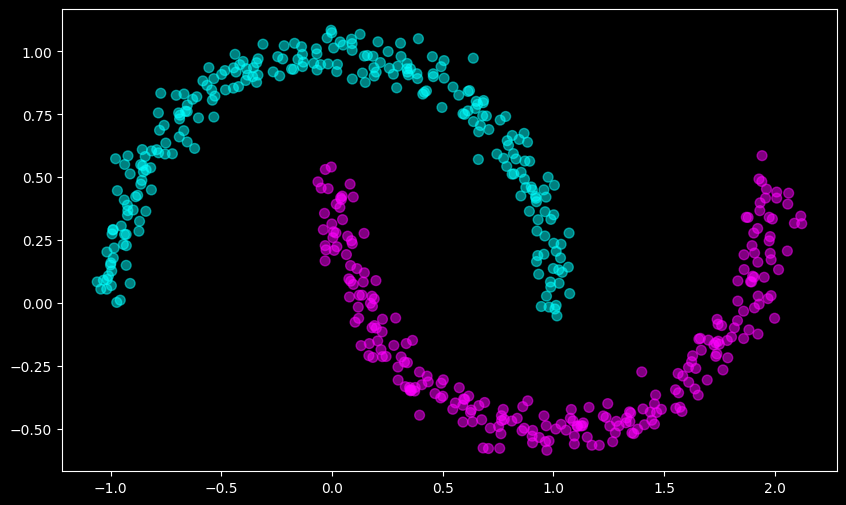

In [7]:
# c de color, cor do ponto depende do y, depende da clase que pertence
# s = size | alpha = transparência do ponto | cmap = color map
# cada cor é uma classe ainda não definida
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, alpha=0.5, cmap="cool")

## Modelo de rede neural
### Construir uma rede neural com 2 entradas, 1 camada escondida com n neurônios e duas saídas

<img src="img/exemplo-1.png" alt="rede" width="400" />

- Inicialização dos pesos e bias
- Feedforward
- Cálculo da perda
- Backpropagation
- Fit = Ajuste do modelo

In [38]:
class NnModel:
    def __init__(self, x: np.ndarray, y: np.ndarray, hidden_neurons: int = 10, output_neurons: int = 2):
        np.random.seed(8)  # "Semente". valores gerados aleatoriamente sejam os mesmos em diferentes execuções.
        self.x = x  # para fazer o treinamento
        self.y = y
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.input_neurons = self.x.shape[1]  # shape[0] = número de Linhas (observações) | shape[1] = número de colunas (entradas)

        # Inicializa os pesos e bias (matrizes)
        # W1 = peso, primeira parte entre a entrada e a camada escondida
        # Xavier Inicialization -> Variancia dos pesos igual em todas as camadas. dividir pela raís quadrada do número de neurônios da entrada
        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons) # Distribuição normal
        self.B1 = np.zeros((1, self.hidden_neurons))  # Baias da camada escondida. Dimensão(1 linha, n de neurônios da camada escondida)
        
        self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons) 
        self.B2 = np.zeros((1, self.output_neurons))  # Bias da camada de saída
        
        # Dicionário para armazenar os pesos e bias (facilita o uso e manipulação do modelo)
        self.model_dict = {"W1": self.W1, "B1": self.B1, "W2": self.W2, "B2": self.B2}
    
        self.z1 = 0  # Somatório que entra na camada escondida que é da primeira parte
        self.f1 = 0  # Quando passar pela função de ativação da camada escondida da primeira parte
        
    
    # forward faz o cálculo da previsão da rede através das entradas que passam pelos pesos, camada escondida e saída
    # f = função de ativação
    # z = soma = equação da reta que chega no neurônio. (entradas x pesos + bias da camada escondida)
    def forward(self, x: np.ndarray) -> np.ndarray:  # -> Função retorna um array
        # Equação da reta(1) que entra na camada escondida. n de colunas da primeira matriz é igual ao numero de linhas da segunda matriz
        self.z1 = x.dot(self.W1) + self.B1  # dot -> (produto entre matrizes) | entrada x vezes w1  + bias 
    
        # Função de ativação(1) Camada 1 da hidden layer
        self.f1 = np.tanh(self.z1)  # Tangente hiperbólica do z1, numpy aplica a a função a cada elemento do vetor z1
        
        # Equação da reta(2) segunda parte, tratando f1 como sendo as entradas para a última camada
        z2 = self.f1.dot(self.W2) + self.B2
        
        # Função de ativação(2)
        # Softmax, passar o resultado da saída pela softmax (para classificação de várias classes). Deixa saídas em valores entre 0 e 1, "probabilidade de cada classe"
        exp_values = np.exp(z2)  # vetor com todos os exponenciais dos valores de f2
        softmax = exp_values / np.sum(exp_values, axis=1, keepdims=True)  # Valor da exponencial dividida pela soma de todos os valores do vetor f2
        return softmax  # Retorna as probabilidades das classes, retorna 1 valor por classe
    
    
    def loss(self, softmax):
        # Cross Entropy -> Apenas calcula a perda para a classe correta
        
        # Varíável que guarda valor da previsão da classe correta
        predictions = np.zeros(self.y.shape[0])
        # Escolhe da função softmax somente a posição da classe correta 
        for i, correct_index in enumerate(self.y):
            predicted = softmax[i][correct_index]  # linha e coluna. Previsão da rede pra classe correta
            predictions[i] = predicted
        
        log_prob = -np.log(predicted)
        return log_prob/self.y.shape[0]  # retorna média da perda
        
        
    # Atualiza os pesos
    def backpropagation(self, softmax: np.ndarray, learning_rate: float) -> None: 
        # linhas do x e coluna y onde está o valor correto  # calcula backpropagation apenas para os valores corretos de previsão
        delta2 = np.copy(softmax)  # softmax é a previsão
        delta2[range(self.x.shape[0]), self.y] -= 1  
        dW2 = (self.f1.T).dot(delta2)  # T = transpor = Transforma linhas em colunas
        dB2 = np.sum(delta2, axis=0, keepdims=True) # Soma das linhas do delta 2
        delta1 = delta2.dot(self.W2.T)*(1-np.power(np.tanh(self.z1), 2))
        dW1 = (self.x.T).dot(delta1)
        dB1 = np.sum(delta1, axis=0, keepdims=True)
        
        # Atualização dos pesos e bias
        self.W1 += - learning_rate*dW1 
        self.W2 += - learning_rate*dW2 
        self.B1 += - learning_rate*dB1 
        self.B2 += - learning_rate*dB2 
        
    
    # Mostra o resultado para cada época de treinamento
    def show_plot(self, predictions):
        if self.x.shape[1] == 2:  # se numero de colunas de x for diferente de 2, sai da função
            plt.scatter(self.x[:,0], self.x[:,1], s = 50, c = predictions, cmap="cool", alpha=0.7)
            plt.show()
        elif self.x.shape[1] == 3:
            ax = plt.axes(projection = '3d')
            ax.scatter3D(x_[:,0], x_[:,1], x_[:,2], s=40, c=predictions, cmap='cool', alpha=0.7)
            plt.show()
        
        
    # Treinamento do modelo
    def fit(self, epochs: int, lr: float, show_plot: bool = False):
        
        for epoch in range(epochs):
            
            # Fazer feedforward, retorna a softmax(probabilidades de cada classe)
            outputs = self.forward(self.x)  # saídas
            loss = self.loss(outputs)
            self.backpropagation(outputs, lr)
        
            # Acuracia
            prediction = np.argmax(outputs, axis=1)  # maior valor de cada coluna
            correct = (prediction == self.y).sum()  # Faz a soma dos valores corretos da previsão
            accuracy = correct/self.y.shape[0]  # Precisão de aprendizagem em porcentagem
            
            if int((epoch+1) % (epochs/10)) == 0:
                print(f"Epoch: [{epoch + 1} / {epochs}]  Accuracy: {accuracy:.5f} Loss: {loss.item():.4f}")
                if show_plot:
                    self.show_plot(prediction)

        return prediction

In [44]:
hidden_neurons = 50
output_neurons = 2
learning_rate = 0.002
epochs = 50

In [45]:
# Cria o modelo
model = NnModel(x, y, hidden_neurons=hidden_neurons, output_neurons=output_neurons)
result = model.fit(epochs, learning_rate)  

Epoch: [5 / 50]  Accuracy: 0.87200 Loss: 0.0000
Epoch: [10 / 50]  Accuracy: 0.88800 Loss: 0.0001
Epoch: [15 / 50]  Accuracy: 0.89000 Loss: 0.0001
Epoch: [20 / 50]  Accuracy: 0.90000 Loss: 0.0001
Epoch: [25 / 50]  Accuracy: 0.90600 Loss: 0.0000
Epoch: [30 / 50]  Accuracy: 0.92000 Loss: 0.0000
Epoch: [35 / 50]  Accuracy: 0.92200 Loss: 0.0000
Epoch: [40 / 50]  Accuracy: 0.93000 Loss: 0.0000
Epoch: [45 / 50]  Accuracy: 0.93800 Loss: 0.0000
Epoch: [50 / 50]  Accuracy: 0.94200 Loss: 0.0000


## Testes e Resultado para visualização de dados

In [11]:
result  # Mostra todas as previsões

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,

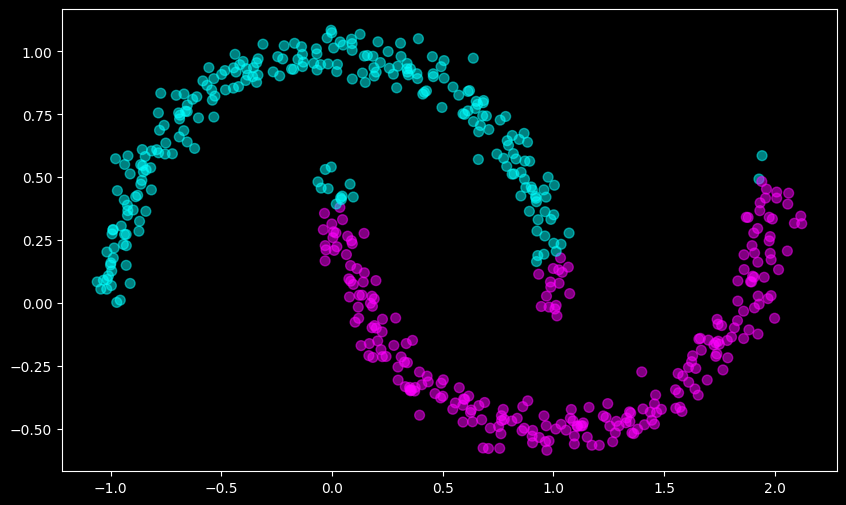

In [12]:
plt.scatter(x[:, 0], x[:, 1], c=result, s=50, alpha=0.5, cmap="cool")

## Cluster dataset 2D

In [40]:
# n_features = numero de variáveis independentes, n de colunas no x ou n de atributos (entradas)
# cluster_std = desvio padrão dos pontos dentro do cluster, mede o quão estes pontos estão distribuidos no centro
# centers = Classes | Random_state -> mesmo resultado padrão de dados em diferentes máquinas | shuffle=True -> Embaralhar os dados
x_, y_ = datasets.make_blobs(n_samples=400, n_features=2, centers=4, random_state=10, cluster_std=0.9, shuffle=True)

In [41]:
# Resultado = 400 linhas(observações) por 2 colunas(features = características)
x_.shape, y_.shape

((400, 2), (400,))

In [42]:
# 4 classes com 100 observações de cada uma
np.unique(y_, return_counts=True)

(array([0, 1, 2, 3]), array([100, 100, 100, 100], dtype=int64))

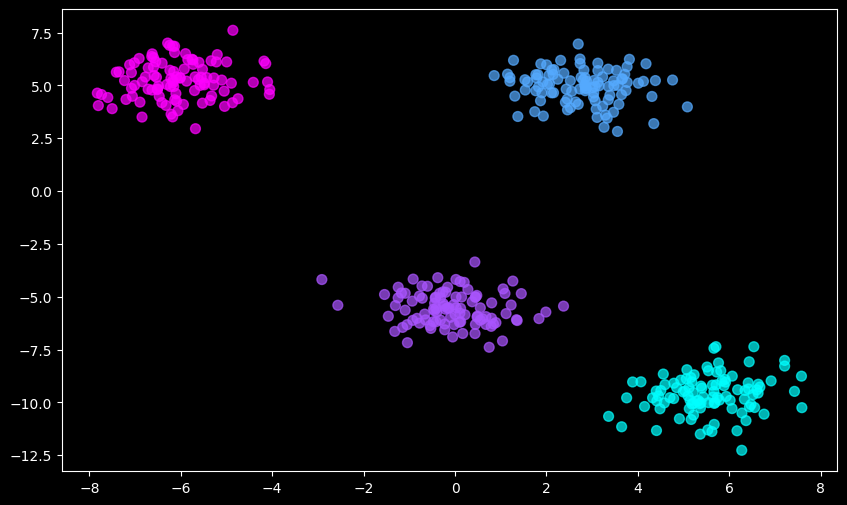

In [43]:
# Gráfico
plt.scatter(x_[:,0], x_[:,1], s = 50, c = y_, cmap="cool", alpha=0.7)

## Modelo para prever de qual classe é cada ponto

In [46]:
hidden_neurons = 50
output_neurons = 4
learning_rate = 0.002
epochs = 50

Epoch: [100 / 1000]  Accuracy: 0.99750 Loss: 0.0000


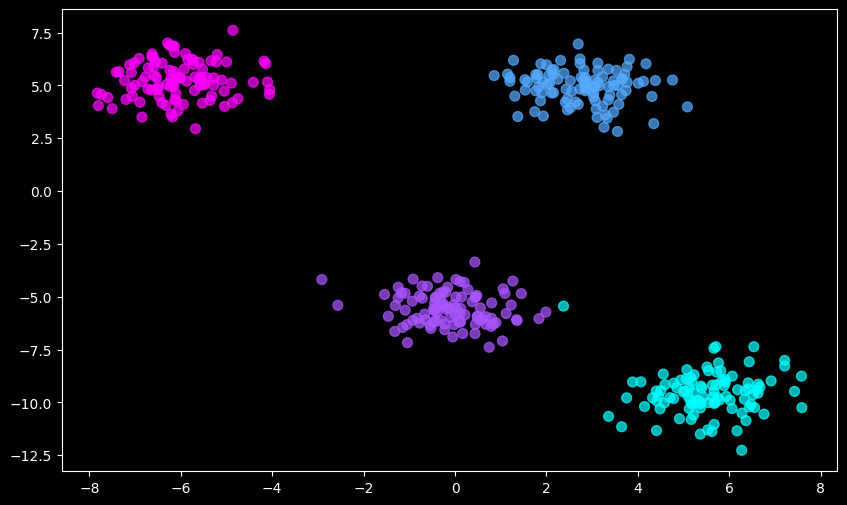

Epoch: [200 / 1000]  Accuracy: 0.99750 Loss: 0.0000


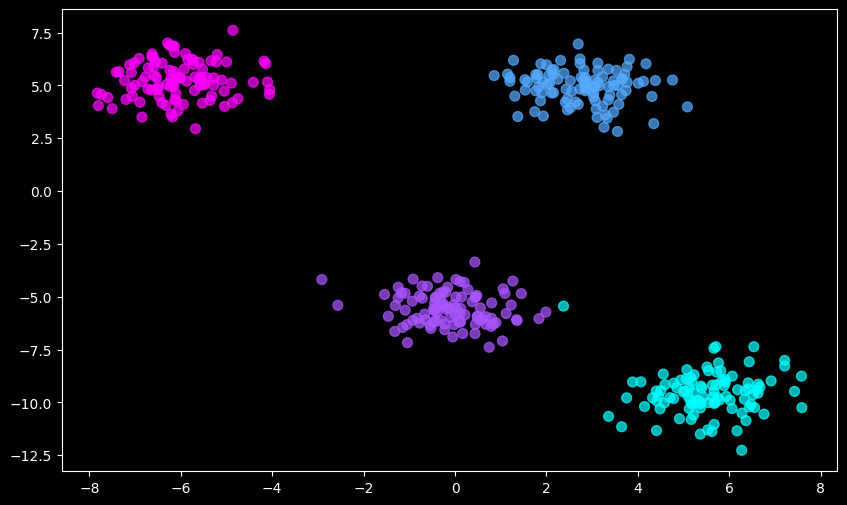

Epoch: [300 / 1000]  Accuracy: 0.99750 Loss: 0.0000


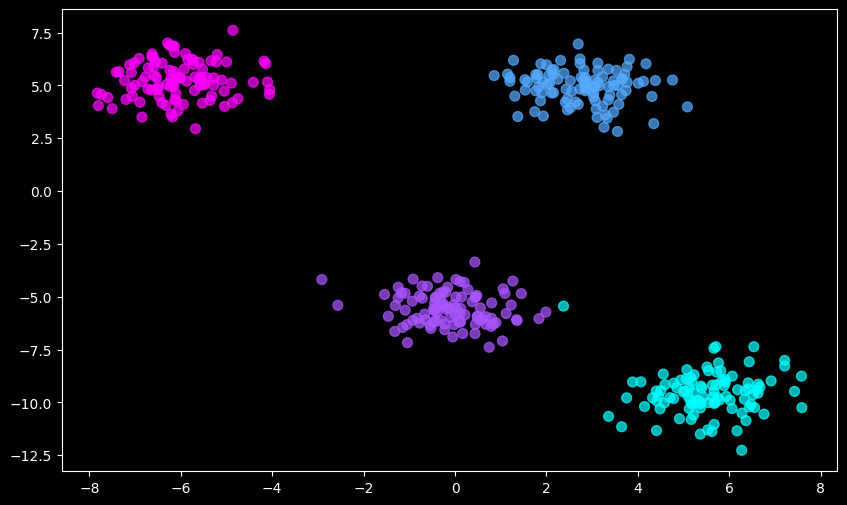

Epoch: [400 / 1000]  Accuracy: 0.99750 Loss: 0.0000


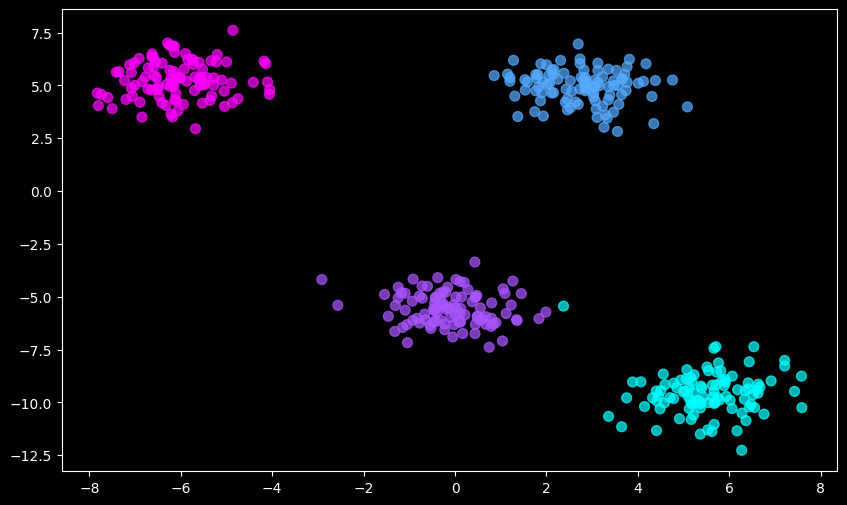

Epoch: [500 / 1000]  Accuracy: 0.99750 Loss: 0.0000


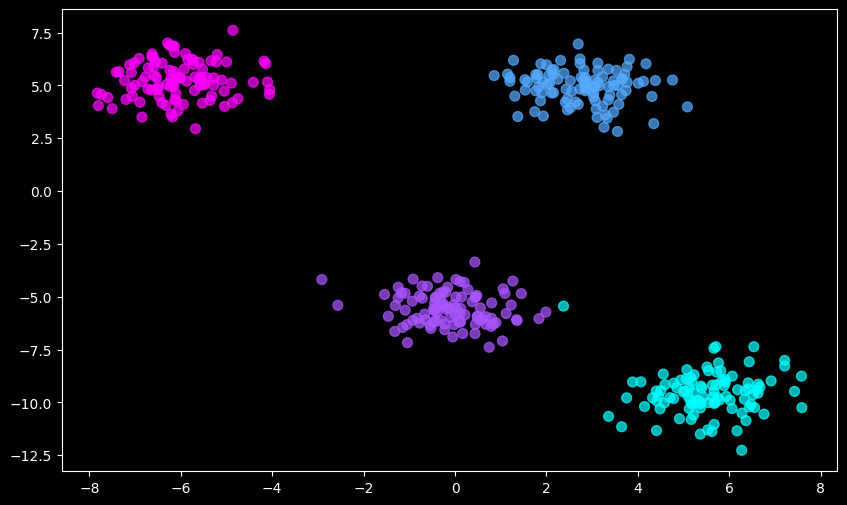

Epoch: [600 / 1000]  Accuracy: 0.99750 Loss: 0.0000


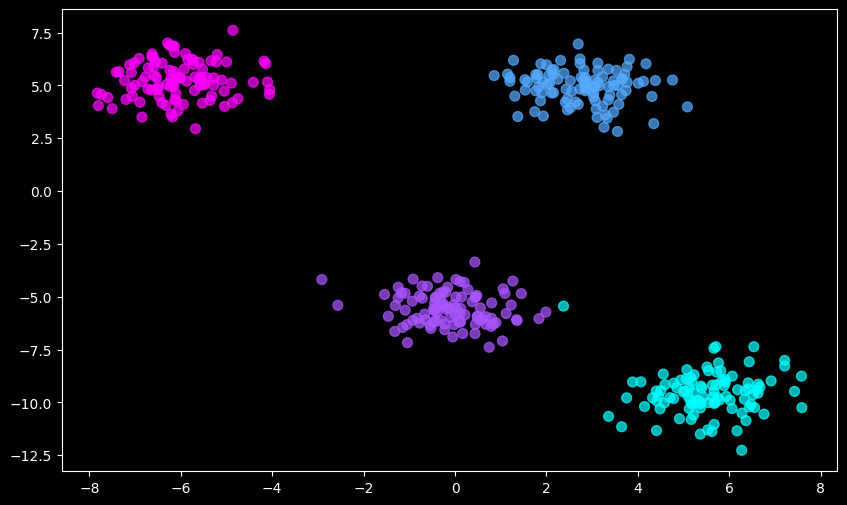

Epoch: [700 / 1000]  Accuracy: 0.99750 Loss: 0.0000


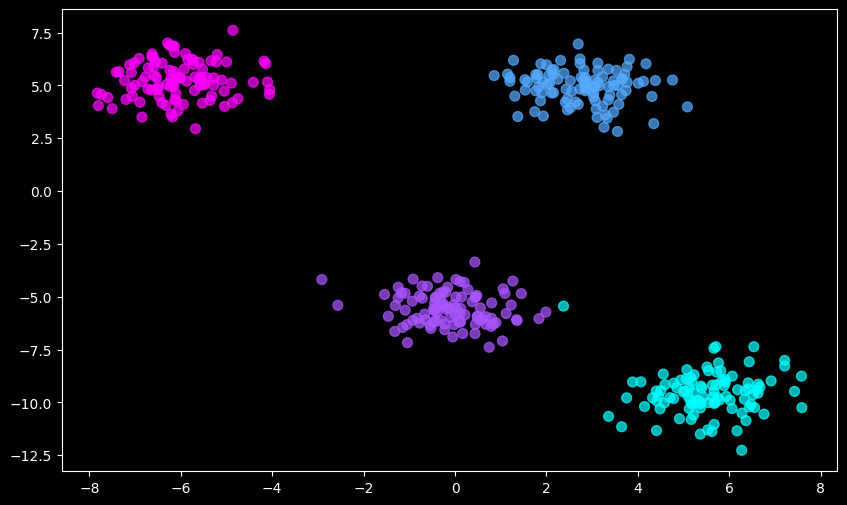

Epoch: [800 / 1000]  Accuracy: 0.99750 Loss: 0.0000


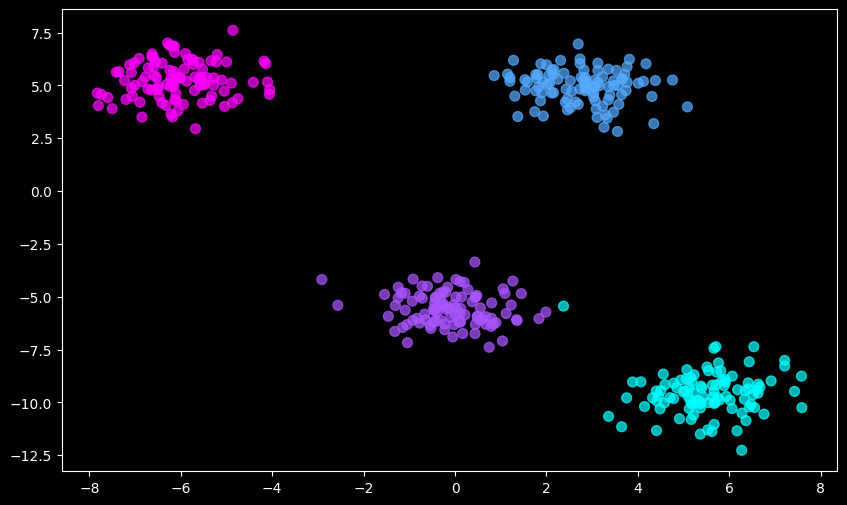

Epoch: [900 / 1000]  Accuracy: 1.00000 Loss: 0.0000


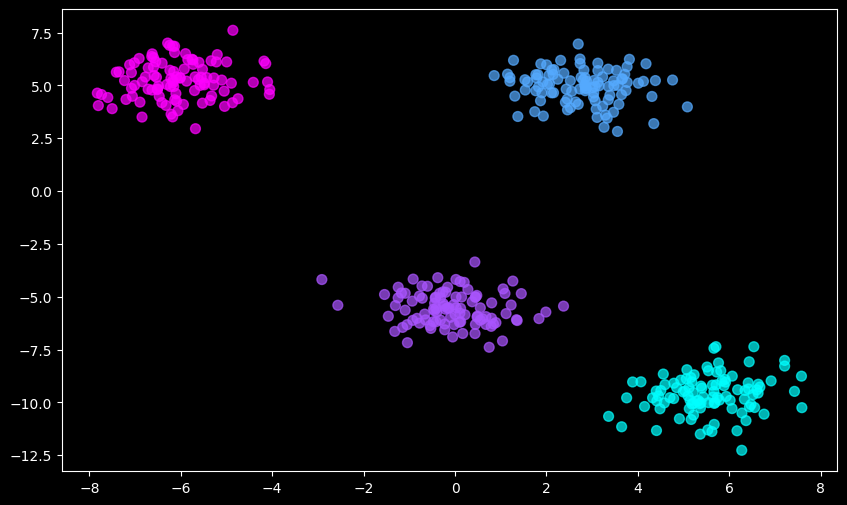

Epoch: [1000 / 1000]  Accuracy: 1.00000 Loss: 0.0000


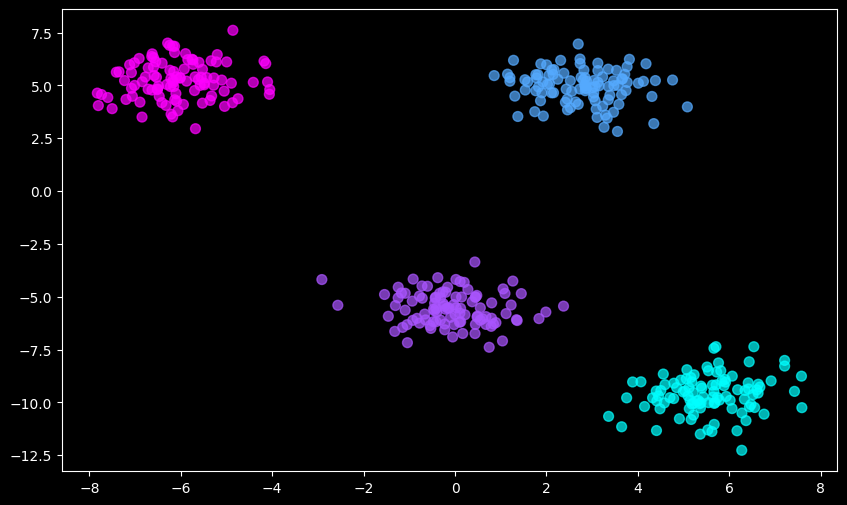

In [48]:
# Cria o modelo
model = NnModel(x_, y_, hidden_neurons=hidden_neurons, output_neurons=output_neurons)
result = model.fit(1000, 0.001, show_plot=True)  

## Cluster dataset 3D

In [27]:
x_, y_ = datasets.make_blobs(n_samples=400, n_features=3, centers=4, random_state=50, cluster_std=0.9, shuffle=True)

In [28]:
x_.shape

(400, 3)

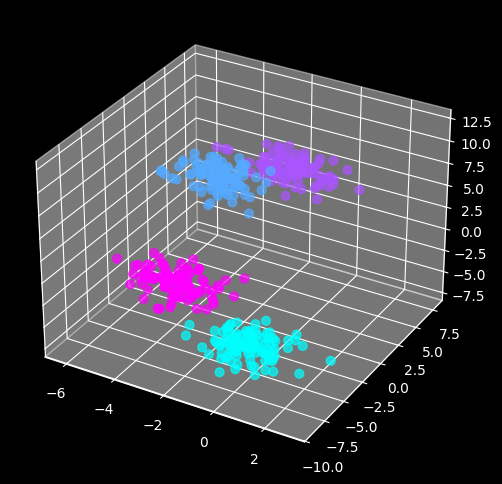

In [29]:
ax = plt.axes(projection = '3d')
ax.scatter3D(x_[:,0], x_[:,1], x_[:,2], s=40, c=y_, cmap='cool', alpha=0.7)

### Modelo

Epoch: [5 / 50]  Accuracy: 0.99500 Loss: 0.0013


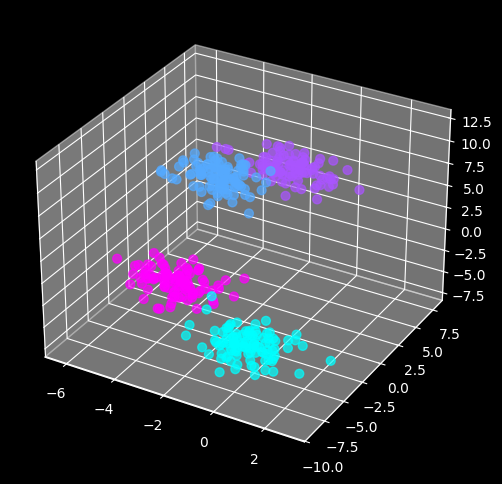

Epoch: [10 / 50]  Accuracy: 1.00000 Loss: 0.0007


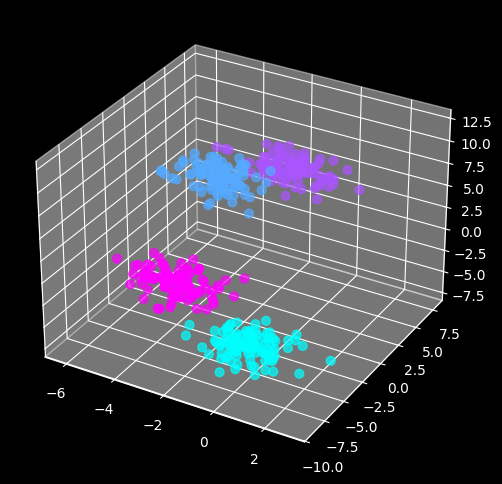

Epoch: [15 / 50]  Accuracy: 1.00000 Loss: 0.0005


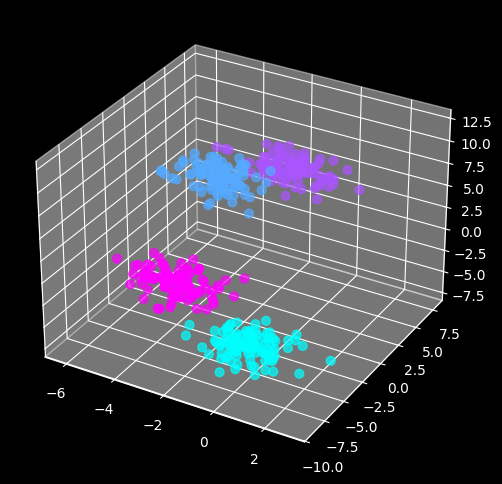

Epoch: [20 / 50]  Accuracy: 1.00000 Loss: 0.0003


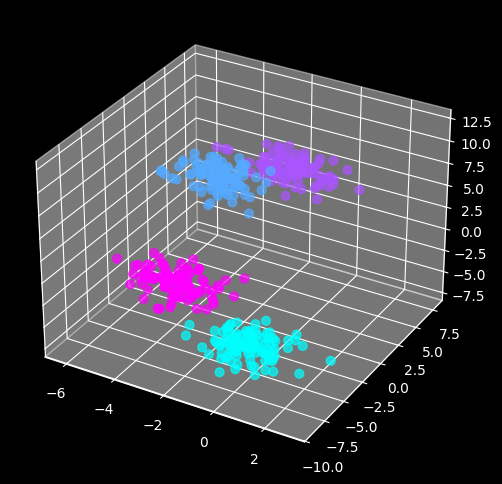

Epoch: [25 / 50]  Accuracy: 1.00000 Loss: 0.0003


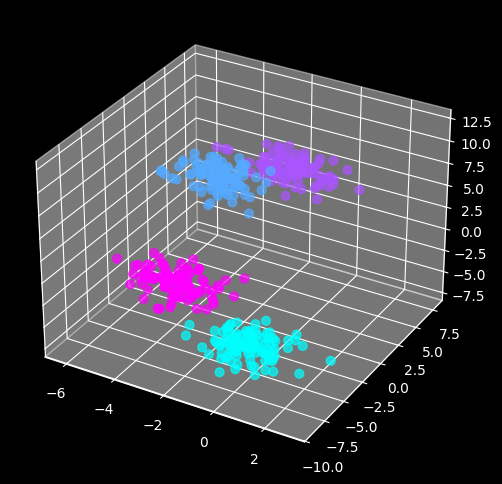

Epoch: [30 / 50]  Accuracy: 1.00000 Loss: 0.0002


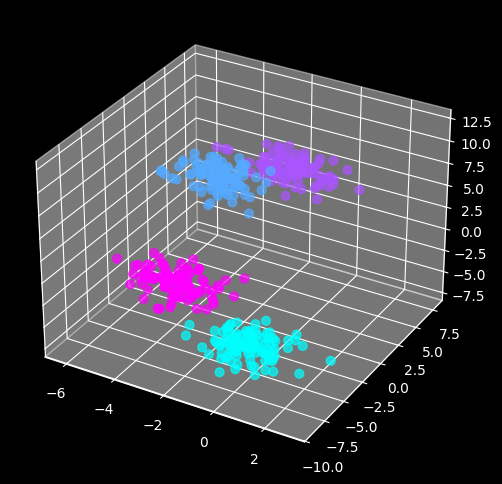

Epoch: [35 / 50]  Accuracy: 1.00000 Loss: 0.0002


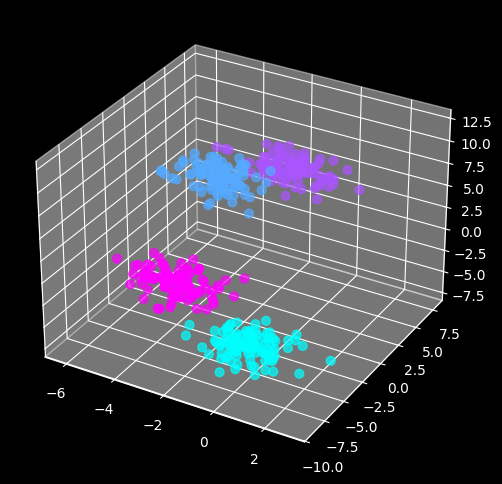

Epoch: [40 / 50]  Accuracy: 1.00000 Loss: 0.0002


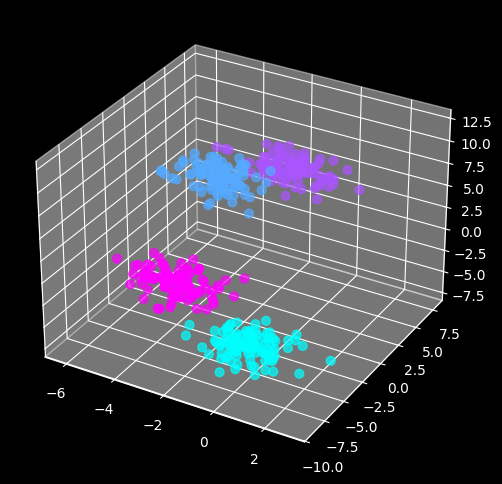

Epoch: [45 / 50]  Accuracy: 1.00000 Loss: 0.0002


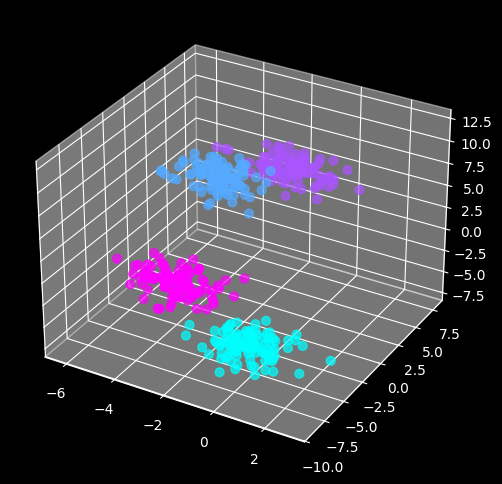

Epoch: [50 / 50]  Accuracy: 1.00000 Loss: 0.0001


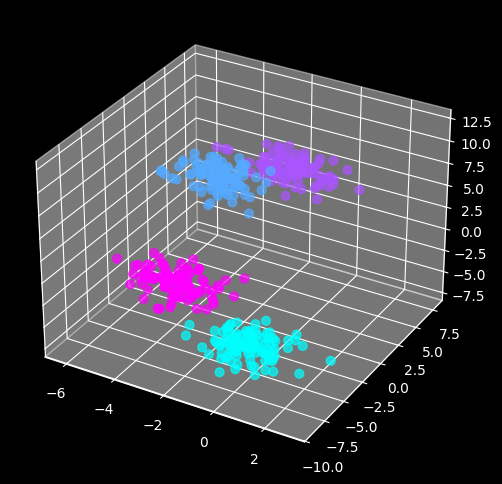

In [39]:
modelo_3d = NnModel(x_, y_, hidden_neurons=10, output_neurons=4)
resultado_3d = modelo_3d.fit(50, 0.001, show_plot=True)

## Exemplos de uso para visualização de matriz

In [22]:
# Instancia o modelo com 10 neurônios na camada escondida e 2 neurônios na camada de saída
modelo = NnModel(x, y, 10, 2)

# Retorna um vetor da softmax
modelo.forward(np.array([0.1, -0.05]))  

array([[0.54762973, 0.45237027]])

In [23]:
softmax = modelo.forward(x)
modelo.loss(softmax)

0.0013704542928162154

In [24]:
# Acessa o dicionário de pesos e bias do modelo
modelo.model_dict 
modelo.model_dict["W1"]  # Exibe a matriz de pesos entre entrada e camada escondida
modelo.model_dict["W1"].shape  # Exibe a forma da matriz W1 (input_neurons(2), hidden_neurons(10))

(2, 10)

In [25]:
v = np.random.randn(10, 2)  # ventor random de duas classes, cada linha tem um valor de previsão para cada classe, neurônio de output, cada um responsável por detectar uma das classes 
v


array([[-0.93434836,  0.08451015],
       [ 0.14369102,  0.07554944],
       [-0.1556451 ,  0.55085006],
       [ 1.70202996,  1.0060937 ],
       [-3.13491977,  1.1395335 ],
       [-1.86979936, -1.77911304],
       [ 0.1277629 , -1.35101776],
       [ 1.5539672 ,  0.69696575],
       [-0.81146115, -1.64325093],
       [ 0.33065887,  1.22495627]])

In [26]:
# keepdims=True deixa na mesma dimensão, de colunas com os valores somados
np.sum(v, axis = 1, keepdims=True)  # axis = 1 -> Colunas | axis = 0 -> Linhas | somar os exponenciais dentro da linha, somando as colunas


array([[-0.8498382 ],
       [ 0.21924046],
       [ 0.39520496],
       [ 2.70812366],
       [-1.99538627],
       [-3.64891239],
       [-1.22325486],
       [ 2.25093295],
       [-2.45471208],
       [ 1.55561514]])